## **1. Import libraries**


In [229]:
# !pip install category_encoders

In [230]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce
import joblib

# from imblearn.over_sampling import SMOTE
# import torch
# from torch.serialization import add_safe_globals
# from skorch.classifier import NeuralNetClassifier
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder, LabelEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay,f1_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier,StackingClassifier
from xgboost import XGBClassifier
from category_encoders import TargetEncoder

## **2. Load dataset**

In [ ]:
dataset_path=r'C:\Users\Acer Nitro\Documents\hoc_ki_6\ĐChurn rate\telecom_customer_churn.csv'
df=pd.read_csv(dataset_path)

## **3. Data Preprocessing**

In [232]:
df = df[df['Monthly Charge'] >= 0]


In [233]:
df['Churn'] = df['Customer Status'].apply(lambda x: 1 if x == 'Churned' else 0)

In [234]:
df.drop(columns=['Customer ID', 'Latitude','Longitude', 'Zip Code', 'Customer Status', 'Churn Category', 'Churn Reason'], inplace=True)

In [235]:
df['Refund_Rate'] = df['Total Refunds'] / (df['Total Revenue'] + 1e-6)

df['Charge_per_Month'] = df['Total Charges'] / (df['Tenure in Months'] + 1e-6)

df['Data_per_Month'] = df['Avg Monthly GB Download'] / (df['Tenure in Months'] + 1e-6)

df['New_Customer'] = df['Tenure in Months'].apply(lambda x: 1 if x <= 6 else 0)

# Tính ngưỡng doanh thu thấp theo phân vị 25%
low_revenue_threshold = df['Total Revenue'].quantile(0.25)

# Gán nhãn cho khách hàng có doanh thu thấp hơn ngưỡng
df['Low_Revenue_Flag'] = df['Total Revenue'].apply(lambda x: 1 if x < low_revenue_threshold else 0)


In [236]:
df=df.drop_duplicates()

In [237]:
# def remove_outliers_iqr(df, columns):
#     for col in columns:
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
#     return df

In [238]:
def remove_outliers_iqr(df, columns):
    mask = pd.Series(True, index=df.index)
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask &= (df[col] >= lower_bound) & (df[col] <= upper_bound)
    return df[mask]

In [239]:
numeric_features=['Age','Monthly Charge','Total Charges','Total Revenue','Total Refunds','Avg Monthly Long Distance Charges','Tenure in Months','Number of Referrals','Avg Monthly GB Download','Total Long Distance Charges','Total Extra Data Charges','Refund_Rate', 'Charge_per_Month', 'Data_per_Month']
df = remove_outliers_iqr(df, numeric_features)

In [240]:
X = df.drop(columns=['Churn'])
y = df['Churn']

In [241]:
rank_features=['Contract','Number of Dependents','New_Customer', 'Low_Revenue_Flag']
target_encode_col = ['City']
non_rank_features = [col for col in X.columns if col not in rank_features + numeric_features + target_encode_col]

In [242]:
preprocessor = ColumnTransformer([
    ('rank', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder()),
        ('scale', StandardScaler())
    ]), rank_features),
    ('numeric', Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ]), numeric_features),
    ('nonrank', Pipeline([
        ('impute', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), non_rank_features)
])

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [244]:
ce_target = TargetEncoder(cols=target_encode_col)
X_train[target_encode_col] = ce_target.fit_transform(X_train[target_encode_col], y_train)
X_test[target_encode_col] = ce_target.transform(X_test[target_encode_col])

In [245]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [246]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Kiểm tra lại phân bố nhãn sau khi oversampling
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 1355, 1: 664})
After SMOTE: Counter({0: 1355, 1: 1355})


c:\Users\Acer Nitro\Anaconda\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [247]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Dự đoán
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # F1 và Accuracy
    print("=== Evaluation Metrics ===")
    print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
    print("Train F1 Score:", f1_score(y_train, y_train_pred))
    print("Test F1 Score :", f1_score(y_test, y_test_pred))

    # Classification report
    print("\nClassification Report (Test set):")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve và AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()


## **1. Random Forest**

In [248]:
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100,150,200],
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [8, 10, 12],
    'max_features': ['sqrt', 'log2']
}
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1'
)
grid_rf.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [8, 10, 12],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='f1', verbose=2)

=== Evaluation Metrics ===
Train Accuracy: 0.8955719557195572
Test Accuracy : 0.8217821782178217
Train F1 Score: 0.8961467889908257
Test F1 Score : 0.7513812154696132

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       327
           1       0.74      0.76      0.75       178

    accuracy                           0.82       505
   macro avg       0.80      0.81      0.81       505
weighted avg       0.82      0.82      0.82       505



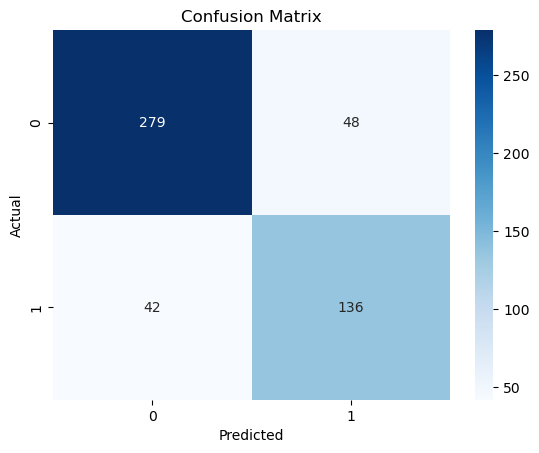

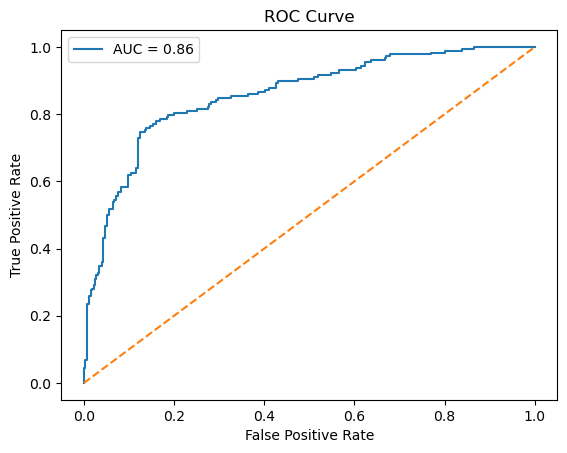

{'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 100}


In [249]:
best_model_rf = grid_rf.best_estimator_
evaluate_model(best_model_rf, X_train_resampled, y_train_resampled, X_test_transformed, y_test)
print(grid_rf.best_params_)

In [250]:
# depths = list(range(1, 21))
# train_accuracies = []
# test_accuracies = []

# for d in depths:
#     current_params = params_gridsearch.copy()
#     current_params['max_depth'] = d
#     train_accuracy, test_accuracy, clf = train_and_evaluate(RandomForestClassifier, current_params)
#     train_accuracies.append(train_accuracy)
#     test_accuracies.append(test_accuracy)

# plt.figure(figsize=(10,6))
# plt.plot(depths, train_accuracies, marker='o', label='Train Accuracy', color='blue')
# plt.plot(depths, test_accuracies, marker='s', label='Test Accuracy', color='red')
# plt.xlabel('max_depth')
# plt.ylabel('Accuracy')
# plt.title('Ảnh hưởng của độ sâu cây (max_depth) đến độ chính xác')
# plt.legend()
# plt.grid(True)
# plt.xticks(depths)
# plt.tight_layout()
# plt.show()

In [251]:
# params_gridsearch['max_depth']=6
# best_params=params_gridsearch
# best_params

In [252]:
# rf_classifier = RandomForestClassifier(**best_params)
# rf_classifier.fit(X_train_selected, y_train)
# y_pred_train = rf_classifier.predict(X_train_selected)
# y_pred_test = rf_classifier.predict(X_test_selected)

# train_accuracy = accuracy_score(y_train, y_pred_train)
# test_accuracy = accuracy_score(y_test, y_pred_test)
# train_and_evaluate(RandomForestClassifier,best_params)

In [253]:
# joblib.dump(rf_classifier, '/content/drive/MyDrive/Đồ án chuyên ngành/model/random_forest_model.pkl')

## **2. Decision Tree**

In [254]:
dt = DecisionTreeClassifier(random_state=42)
param_grid_dt= {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

grid_dt.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1', verbose=2)

=== Evaluation Metrics ===
Train Accuracy: 0.9103321033210332
Test Accuracy : 0.7485148514851485
Train F1 Score: 0.912621359223301
Test F1 Score : 0.6576819407008087

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       327
           1       0.63      0.69      0.66       178

    accuracy                           0.75       505
   macro avg       0.73      0.73      0.73       505
weighted avg       0.75      0.75      0.75       505



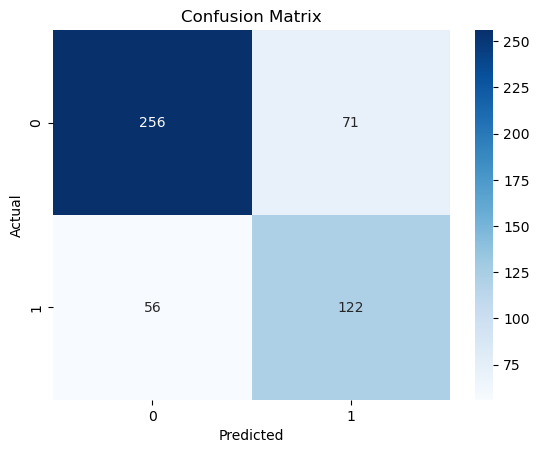

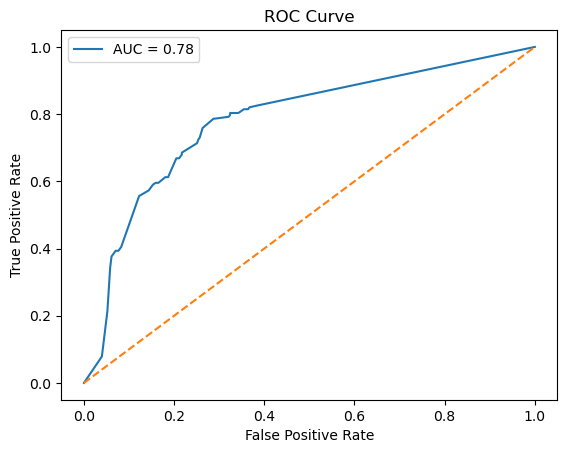

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [255]:
best_model_dt = grid_dt.best_estimator_
evaluate_model(best_model_dt, X_train_resampled, y_train_resampled, X_test_transformed, y_test)
print(grid_dt.best_params_)

In [256]:
# dt = DecisionTreeClassifier(random_state=42)
# path = dt.cost_complexity_pruning_path(X_train_selected, y_train)
# ccp_alphas = path.ccp_alphas
# ccp_alphas = np.unique(np.round(path.ccp_alphas, 5))
# param_grid = {
#     'ccp_alpha': ccp_alphas,
#     'max_depth': [3, 5, 10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'criterion': ['gini', 'entropy']
# }

# grid_search = GridSearchCV(
#     estimator=dt,
#     param_grid=param_grid,
#     cv=5,
#     scoring='accuracy',
#     verbose=2,
#     n_jobs=-1
# )

# grid_search.fit(X_train_selected, y_train)


# print("Best parameters found:")
# print(grid_search.best_params_)

# print("\nBest CV accuracy:")
# print(grid_search.best_score_)

# best_dt_model = grid_search.best_estimator_
# y_pred = best_dt_model.predict(X_test_selected)

# print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))


In [257]:
# params_gridsearch=grid_search.best_params_
# params_gridsearch

In [258]:
# depths = list(range(1, 21))
# train_accuracies = []
# test_accuracies = []

# for d in depths:
#     params = params_gridsearch.copy()
#     params['max_depth'] = d
#     train_accuracy, test_accuracy,clf=train_and_evaluate(DecisionTreeClassifier,params)
#     train_accuracies.append(train_accuracy)
#     test_accuracies.append(test_accuracy)

# plt.figure(figsize=(10,6))
# plt.plot(depths, train_accuracies, marker='o', label='Train Accuracy', color='blue')
# plt.plot(depths, test_accuracies, marker='s', label='Test Accuracy', color='red')
# plt.xlabel('max_depth')
# plt.ylabel('Accuracy')
# plt.title('Ảnh hưởng của độ sâu cây (max_depth) đến độ chính xác')
# plt.legend()
# plt.grid(True)
# plt.xticks(depths)
# plt.tight_layout()
# plt.show()

In [259]:
# best_params=params_gridsearch

In [260]:
# decision_classifier=DecisionTreeClassifier(**best_params)
# decision_classifier.fit(X_train_selected, y_train)
# train_and_evaluate(DecisionTreeClassifier,best_params)

In [261]:
# joblib.dump(decision_classifier, '/content/drive/MyDrive/Đồ án chuyên ngành/model/decision_tree_model.pkl')



## **3. LSTM**






In [262]:
# X_train_selected.shape

In [263]:
# import numpy as np
# import torch
# from torch import nn
# from skorch import NeuralNetClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV

# # ➕ Reshape thành (samples, timesteps=1, features)
# X_train = X_train_selected.reshape(-1, 1, X_train_selected.shape[1])
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train_LSTM = torch.tensor(y_train.values, dtype=torch.float32)

# # Mô hình LSTM trong PyTorch
# class LSTMClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim=32):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, 1)

#     def forward(self, x):
#         _, (h_n, _) = self.lstm(x)
#         out = self.fc(h_n[-1])            # lấy hidden state cuối
#         return torch.sigmoid(out).squeeze(1)  # sigmoid để phân loại nhị phân

# # Tạo skorch wrapper
# net = NeuralNetClassifier(
#     module=LSTMClassifier,
#     module__input_dim=26,
#     module__hidden_dim=32,
#     max_epochs=10,
#     lr=0.001,
#     criterion=nn.BCELoss,
#     optimizer=torch.optim.Adam,
#     train_split=None,
#     verbose=1,
#     device="cpu"  # dùng "cuda" nếu có GPU
# )

# # Grid search
# params = {
#     'module__hidden_dim': [16, 32],
#     'lr': [0.001, 0.01],
#     'max_epochs': [50]
# }

# grid = RandomizedSearchCV(net, params, cv=3, verbose=1)
# grid.fit(X_train, y_train_LSTM)

# # Kết quả
# print("Best parameters:", grid.best_params_)
# print("Best CV score:", grid.best_score_)


In [264]:
# # Best parameters: {'lr': 0.001, 'max_epochs': 20, 'module__hidden_dim': 32}
# # train model lstm

# from skorch.helper import predefined_split
# from skorch.callbacks import EpochScoring


# best_params = grid.best_params_
# print(best_params)

# model_lstm = NeuralNetClassifier(
#     module=LSTMClassifier,
#     module__input_dim=26,
#     module__hidden_dim=best_params['module__hidden_dim'],
#     max_epochs=20,
#     lr=best_params['lr'],
#     criterion=nn.BCELoss,
#     optimizer=torch.optim.Adam,
#     train_split=predefined_split(torch.utils.data.TensorDataset(
#         torch.tensor(X_test_selected.reshape(-1, 1, X_test_selected.shape[1]), dtype=torch.float32),
#         torch.tensor(y_test.values, dtype=torch.float32)
#     )),
#     # epochscoring dùng để tính toán và ghi lại các giá trị acc, f1...
#     callbacks=[
#         EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
#         EpochScoring(scoring='accuracy', name='valid_acc', on_train=False)
#     ],
#     verbose=1,
#     device="cpu"
# )

# model_lstm.fit(X_train, y_train_LSTM)



In [265]:
# train_acc = []
# valid_acc = []
# for i, epochs in enumerate(model_lstm.history):
#      train_acc.append(epochs['train_acc'])
#      valid_acc.append(epochs['valid_acc'])

# # Create a list of epoch numbers for the x-axis
# epochs_num = list(range(1, len(train_acc) + 1))

# plt.figure(figsize=(10,6))
# # Use epochs_num as the x-axis data
# plt.plot(epochs_num, train_acc, marker='o', label='Train Accuracy', color='blue')
# plt.plot(epochs_num, valid_acc, marker='s', label='Test Accuracy', color='red')
# plt.xlabel('epochs')
# plt.ylabel('Accuracy')
# plt.title('LSTM')
# plt.legend()
# plt.grid(True)
# # plt.xticks(20) # No need for this line anymore
# plt.tight_layout()
# plt.show()

In [266]:

# torch.save(model_lstm, '/content/drive/MyDrive/Đồ án chuyên ngành/model/best_lstm_model.pt')

## **4. SVM**

In [267]:
svm = SVC(kernel='rbf', C=1, gamma='scale')

param_grid_svc = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 'scale'],
    'kernel': ['rbf']
}

grid_search_svc = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svc,
    cv=5,
    scoring='f1',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

grid_search_svc.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=SVC(C=1), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 'scale'],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='f1', verbose=2)

=== Evaluation Metrics ===
Train Accuracy: 0.996309963099631
Test Accuracy : 0.7425742574257426
Train F1 Score: 0.9963235294117647
Test F1 Score : 0.6242774566473989

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       327
           1       0.64      0.61      0.62       178

    accuracy                           0.74       505
   macro avg       0.72      0.71      0.71       505
weighted avg       0.74      0.74      0.74       505



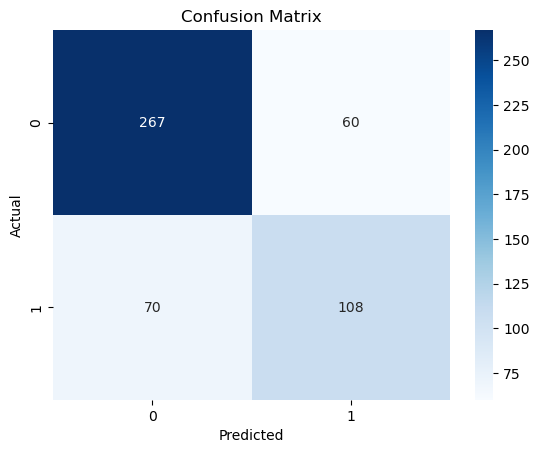

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [268]:
best_model_svm = grid_search_svc.best_estimator_
evaluate_model(best_model_svm, X_train_resampled, y_train_resampled, X_test_transformed, y_test)
print(grid_search_svc.best_params_)

In [269]:
# svm_classifier=SVC(**random_search.best_params_)
# svm_classifier.fit(X_train_selected, y_train)
# train_and_evaluate(SVC,random_search.best_params_)

In [270]:
# joblib.dump(svm_classifier,'/content/drive/MyDrive/Đồ án chuyên ngành/model/svm_model.pkl')

In [271]:
# results = pd.DataFrame(random_search.cv_results_)

# results = results.sort_values(by="mean_test_score", ascending=False)

# plt.plot(results["mean_train_score"], label='Train Accuracy', marker='o', color='blue')
# plt.plot(results["mean_test_score"], label='Test Accuracy', marker='s', color='red')
# plt.xlabel("Model (sorted by test accuracy)")
# plt.ylabel("Accuracy")
# plt.title("So sánh độ chính xác giữa tập train và test theo từng mô hình (SVM)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

## **5. Gradient Boost**

In [272]:
param_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'subsample': [0.7, 0.8]
}

gb_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=param_gb,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

gb_grid.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05], 'max_depth': [3, 5],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200], 'subsample': [0.7, 0.8]},
             scoring='f1', verbose=2)

=== Evaluation Metrics ===
Train Accuracy: 0.9195571955719557
Test Accuracy : 0.8257425742574257
Train F1 Score: 0.9204959883296864
Test F1 Score : 0.7582417582417582

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       327
           1       0.74      0.78      0.76       178

    accuracy                           0.83       505
   macro avg       0.81      0.81      0.81       505
weighted avg       0.83      0.83      0.83       505



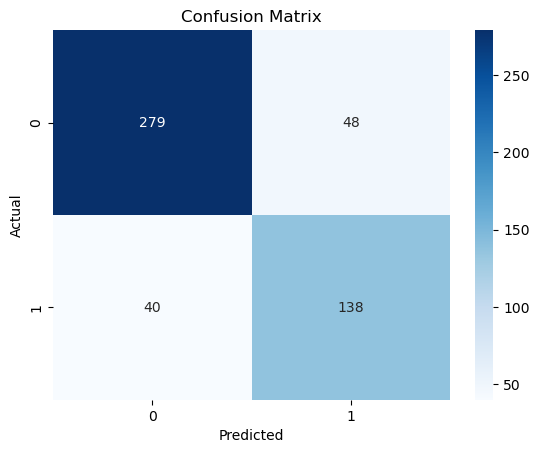

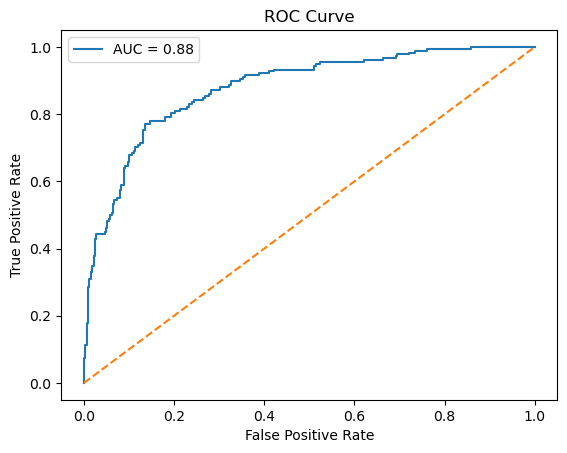

{'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.7}


In [273]:
best_model_gb = gb_grid.best_estimator_
evaluate_model(best_model_gb, X_train_resampled, y_train_resampled, X_test_transformed, y_test)
print(gb_grid.best_params_)

In [274]:

# depths = list(range(1, 11))
# train_accuracies = []
# test_accuracies = []

# for d in depths:
#     gb_grid.best_params_['max_depth']=d
#     train_accuracy, test_accuracy,clf=train_and_evaluate(GradientBoostingClassifier,gb_grid.best_params_)
#     train_accuracies.append(train_accuracy)
#     test_accuracies.append(test_accuracy)

# plt.figure(figsize=(10,6))
# plt.plot(depths, train_accuracies, marker='o', label='Train Accuracy', color='blue')
# plt.plot(depths, test_accuracies, marker='s', label='Test Accuracy', color='red')
# plt.xlabel('max_depth')
# plt.ylabel('Accuracy')
# plt.title('Ảnh hưởng của độ sâu cây (max_depth) đến độ chính xác')
# plt.legend()
# plt.grid(True)
# plt.xticks(depths)
# plt.tight_layout()
# plt.show()

In [275]:
# gb_grid.best_params_['max_depth']=8

In [276]:
# gb_model = GradientBoostingClassifier(**gb_grid.best_params_)
# gb_model.fit(X_train_selected, y_train)
# train_and_evaluate(GradientBoostingClassifier,gb_grid.best_params_)


In [277]:
# joblib.dump(gb_model, '/content/drive/MyDrive/Đồ án chuyên ngành/model/best_gb_model.pkl')

## **6. AdaBoost**

In [278]:
param_adb = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1],
    }

base = DecisionTreeClassifier(max_depth=1)
adb_grid = GridSearchCV(
    estimator=AdaBoostClassifier(base),
    param_grid =param_adb,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

adb_grid.fit(X_train_resampled, y_train_resampled)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1)),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1', verbose=2)

=== Evaluation Metrics ===
Train Accuracy: 0.7981549815498155
Test Accuracy : 0.7584158415841584
Train F1 Score: 0.8090750436300175
Test F1 Score : 0.698019801980198

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       327
           1       0.62      0.79      0.70       178

    accuracy                           0.76       505
   macro avg       0.75      0.77      0.75       505
weighted avg       0.78      0.76      0.76       505



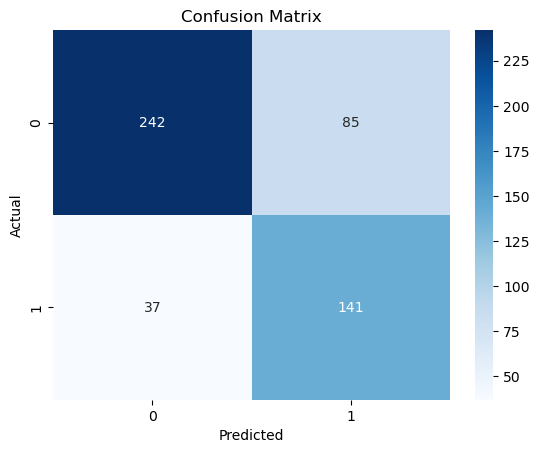

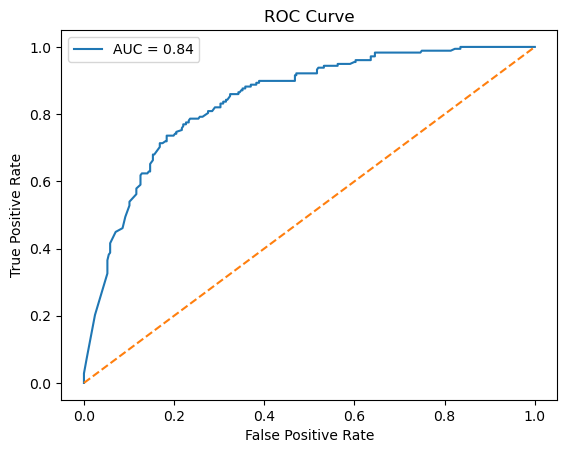

{'learning_rate': 0.1, 'n_estimators': 300}


In [279]:
best_model_adb = adb_grid.best_estimator_
evaluate_model(best_model_adb, X_train_resampled, y_train_resampled, X_test_transformed, y_test)
print(adb_grid.best_params_)

In [280]:
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=adb_grid.best_estimator_,
#     X=X_train_selected,
#     y=y_train,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     train_sizes=np.linspace(0.1, 1.0, 10),
#     verbose=1
# )

# train_mean = np.mean(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)

# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_mean, label="Training Accuracy", marker='o')
# plt.plot(train_sizes, test_mean, label="Test Accuracy", marker='s')
# plt.xlabel("Training Set Size")
# plt.ylabel("Accuracy")
# plt.title("Learning Curve - AdaBoost")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [281]:
# adb_model = AdaBoostClassifier(**adb_grid.best_params_)
# adb_model.fit(X_train_selected, y_train)
# train_and_evaluate(AdaBoostClassifier,adb_grid.best_params_)


In [282]:
# joblib.dump(adb_model, '/content/drive/MyDrive/Đồ án chuyên ngành/model/best_adb_model.pkl')

## **7. XGBoost**

In [283]:
param_grid_xgb = {
    'n_estimators': [100,150,200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [1, 5]
}

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Users\Acer Nitro\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:36:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8],
                         'learning_rate': [0.01, 0.05], 'max_depth': [2, 3, 4],
                         'n_estimators': [100, 150, 200],
                         'reg_alpha': [0.1, 0.5], 'reg_lambda': [1, 5],
                         'subsample': [0.6, 0.8]},
             scoring='f1', verbose=1)

=== Evaluation Metrics ===
Train Accuracy: 0.9147601476014761
Test Accuracy : 0.8158415841584158
Train F1 Score: 0.915785636164783
Test F1 Score : 0.7365439093484419

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       327
           1       0.74      0.73      0.74       178

    accuracy                           0.82       505
   macro avg       0.80      0.80      0.80       505
weighted avg       0.82      0.82      0.82       505



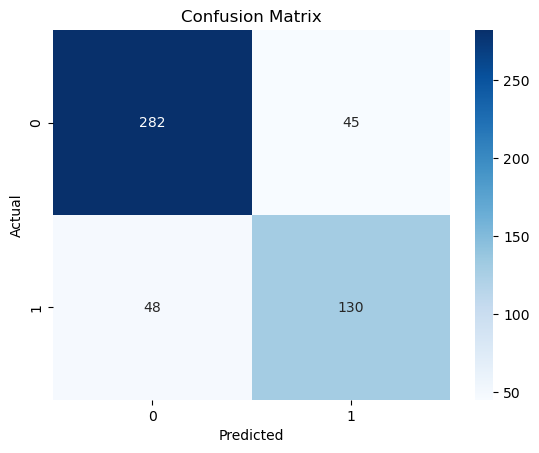

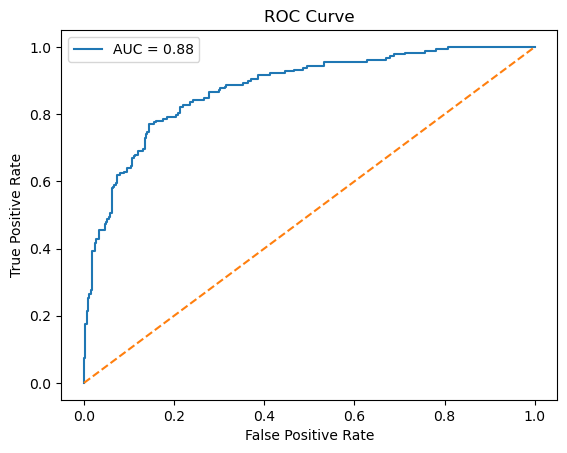

{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.6}


In [284]:
best_model_xgb = grid_xgb.best_estimator_
evaluate_model(best_model_xgb, X_train_resampled, y_train_resampled, X_test_transformed, y_test)
print(grid_xgb.best_params_)

In [285]:
# params_gridsearch=grid_search.best_params_
# params_gridsearch

In [286]:
# depths = list(range(1, 21))
# train_accuracies = []
# test_accuracies = []

# for d in depths:
#     current_params = params_gridsearch.copy()
#     current_params['max_depth'] = d
#     train_accuracy, test_accuracy, clf = train_and_evaluate(XGBClassifier, current_params)
#     train_accuracies.append(train_accuracy)
#     test_accuracies.append(test_accuracy)

# plt.figure(figsize=(10,6))
# plt.plot(depths, train_accuracies, marker='o', label='Train Accuracy', color='blue')
# plt.plot(depths, test_accuracies, marker='s', label='Test Accuracy', color='red')
# plt.xlabel('max_depth')
# plt.ylabel('Accuracy')
# plt.title('Ảnh hưởng của độ sâu cây (max_depth) đến độ chính xác')
# plt.legend()
# plt.grid(True)
# plt.xticks(depths)
# plt.tight_layout()
# plt.show()

In [287]:
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=best_xgb,
#     X=X_train_selected,
#     y=y_train,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     train_sizes=np.linspace(0.1, 1.0, 10),
#     verbose=1
# )

# train_mean = np.mean(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)

# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_mean, label="Training Accuracy", marker='o')
# plt.plot(train_sizes, test_mean, label="Test Accuracy", marker='s')
# plt.xlabel("Training Set Size")
# plt.ylabel("Accuracy")
# plt.title("Learning Curve - XGBoost")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [288]:
# best_params=grid_search.best_params_
# xgb_model = XGBClassifier(**best_params)
# xgb_model.fit(X_train_selected, y_train)
# print(train_and_evaluate(XGBClassifier,best_params))


In [289]:
# joblib.dump(xgb_model, '/content/drive/MyDrive/Đồ án chuyên ngành/model/xgb_model.pkl')

In [290]:
# model = joblib.load("/content/drive/MyDrive/Đồ án chuyên ngành/model/xgb_model.pkl")

# y_pred_train = model.predict(X_train_selected)
# y_pred_test = model.predict(X_test_selected)

# train_acc = accuracy_score(y_train, y_pred_train)
# test_acc = accuracy_score(y_test, y_pred_test)

# print(f"🎯 Độ chính xác trên tập huấn luyện (train): {train_acc:.4f}")
# print(f"🧪 Độ chính xác trên tập kiểm tra (test): {test_acc:.4f}")

## Stacking

In [291]:

meta_model = Pipeline([
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100), threshold="median")),
    ('log_reg', LogisticRegression(C=0.1, penalty='l2', max_iter=1000))
])


=== Evaluation Metrics ===
Train Accuracy: 0.9158671586715867
Test Accuracy : 0.8198019801980198
Train F1 Score: 0.9173313995649021
Test F1 Score : 0.7520435967302452

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       327
           1       0.73      0.78      0.75       178

    accuracy                           0.82       505
   macro avg       0.80      0.81      0.81       505
weighted avg       0.82      0.82      0.82       505



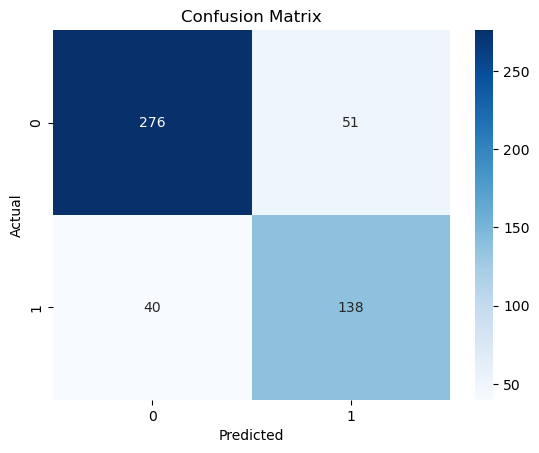

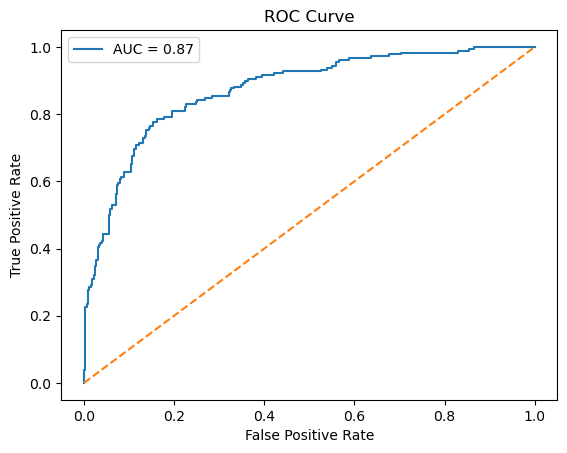

In [292]:
estimators = [
    ('rf', RandomForestClassifier(**grid_rf.best_params_)),
    ('gb', GradientBoostingClassifier(**gb_grid.best_params_)),
    ('xgb', XGBClassifier(**grid_xgb.best_params_)),
    ('dt', DecisionTreeClassifier(**grid_dt.best_params_)),
    ('adb', AdaBoostClassifier(**adb_grid.best_params_))
]

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# Train stacking model
stacking.fit(X_train_resampled, y_train_resampled)

# Đánh giá
evaluate_model(stacking, X_train_resampled, y_train_resampled, X_test_transformed, y_test)


In [294]:
joblib.dump(ce_target, 'target_encoder.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(stacking, 'stacking_model.pkl')

['stacking_model.pkl']

In [ ]:
# add_safe_globals([NeuralNetClassifier])
# model_lstm = torch.load('/content/drive/MyDrive/Đồ án chuyên ngành/model/best_lstm_model.pt')
# models = {
#     "ada": joblib.load("/content/drive/MyDrive/Đồ án chuyên ngành/model/best_adb_model.pkl"),
#     "gb": joblib.load("/content/drive/MyDrive/Đồ án chuyên ngành/model/best_gb_model.pkl"),
#     "xgb": joblib.load("/content/drive/MyDrive/Đồ án chuyên ngành/model/xgb_model.pkl"),
#     "svm": joblib.load("/content/drive/MyDrive/Đồ án chuyên ngành/model/svm_model.pkl"),
#     "dt": joblib.load("/content/drive/MyDrive/Đồ án chuyên ngành/model/decision_tree_model.pkl"),
#     "rf": joblib.load("/content/drive/MyDrive/Đồ án chuyên ngành/model/random_forest_model.pkl"),
#     "lstm": model_lstm
# }

In [ ]:
# LSTM
y_pred_lstm = model_lstm.predict(X_test_selected)
print(classification_report(y_test, y_pred_lstm))

NameError: name 'model_lstm' is not defined

In [ ]:
# ada
y_pred_ada = models["ada"].predict(X_test_selected)
print(classification_report(y_test, y_pred_ada))

In [ ]:
# gb
y_pred_gb = models["gb"].predict(X_test_selected)
print(classification_report(y_test, y_pred_gb))

In [ ]:
# xgb
y_pred_xgb = models["xgb"].predict(X_test_selected)
print(classification_report(y_test, y_pred_xgb))

In [ ]:
# svm
y_pred_svm = models["svm"].predict(X_test_selected)
print(classification_report(y_test, y_pred_svm))

In [ ]:
# dt
y_pred_dt = models["dt"].predict(X_test_selected)
print(classification_report(y_test, y_pred_dt))

In [ ]:
# rf
y_pred_rf = models["rf"].predict(X_test_selected)
print(classification_report(y_test, y_pred_rf))